In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

First we will read in a file that contains the overall list of all the available datasets, with corresponding star IDs, $\nu_{max}$ and $\sigma_{\nu_{max}}$ values. From this we will take a random selection for our analysis.

In [2]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
# Select a random number of stars from the file, recording their IDs
IDs = [random.choice(output['ID']) for i in range(6)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax_err'] for i in range(len(IDs))]

Using our list of selected stars, we can then pull the respective files containing the induvidual mode frequencies and errors. The different files will contain varying numbers of modes; in order to successfully parse the data through Stan, one must ensure that all the arrays are of the same length. To do this, for every dataset that contains less modes than the most complete dataset, we can produce additional modes based on the average frequency spacing $\left<\Delta\nu\right>$ for each star, ensuring to assign these points with a large uncertainty so that Stan does not use this as restrictive points during the fit (they are essentially ignored).

In [3]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
    
dnu_avgarr = np.asarray(dnu_avgID)

The data for the different stars can be viewed on an Échelle Diagram.

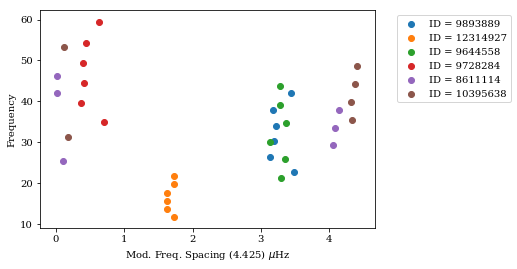

In [4]:
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.savefig('seminar/manyrgbs.pdf')
plt.show()

With all our required data, we can parse the data into a stan model constructed to perform a hierarchical Bayesian model. Hyperpriors have been introduced on a number of parameters based on values in the Vrard (2014) paper.

In [10]:
code = '''
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
}
parameters {
    real dnu[N];
    real nmax[N];
    real epsilon[N];
    real alpha[N];
    real<lower = 0> A[N];
    real<lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}

transformed parameters {
    real tau_t[N];
    for (i in 1:N){
        tau_t[i] = Ktruestd[i] * sigma + mu;
    }
}


model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = (n[i,j] + epsilon[i] + (alpha[i]/2) * (nmax[i] - n[i,j])^2 + 
                A[i]*G[i]/(2*pi()) * sin((2*pi()*(n[i,j]-nmax[i]))/G[i] + phi[i]))*dnu[i]*
                exp(-n[i,j]/tau[i]);
            mod[j] ~ normal(freq[i], freq_err[i]);
        }
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
        epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
    }
    
    //epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    //A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    
    G ~ normal(3.08, 0.65);
    tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00f960a035d810bbec594fa3d8c9432c NOW.


In [11]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'epsilon': epsilon,
         'alpha': alpha,
         'A': A,
         'G': G,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88,
         'tau': tau
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=10000, chains=nchains, init=[start for n in range(nchains)])

In [12]:
print(fit)

Inference for Stan model: anon_model_00f960a035d810bbec594fa3d8c9432c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]       3.85  2.2e-5 3.9e-3   3.85   3.85   3.85   3.86   3.86  32294    1.0
dnu[2]       2.01  1.1e-5 2.0e-3    2.0   2.01   2.01   2.01   2.01  33963    1.0
dnu[3]       4.48  2.5e-5 4.4e-3   4.47   4.48   4.48   4.49   4.49  30291    1.0
dnu[4]       4.89  3.0e-5 4.8e-3   4.88   4.89   4.89    4.9    4.9  26115    1.0
dnu[5]       4.21  2.5e-5 4.2e-3    4.2    4.2   4.21   4.21   4.21  28094    1.0
dnu[6]       4.43  2.9e-5 4.5e-3   4.42   4.42   4.43   4.43   4.43  24446    1.0
nmax[1]     18.51    0.22   1.36  15.73   17.6  18.56  19.45  21.09     40   1.08
nmax[2]     17.62    0.23   1.71  13.56  16.87  17.76  18.68  20.38     56   1.05
nmax[3]     14.43     0.4   1.84   9.75  13.54  14.69   15.7  17.23    

In [13]:
%matplotlib tk
fit.plot()
plt.show()

INFO:matplotlib.backends._backend_tk:Could not load matplotlib icon: can't use "pyimage11" as iconphoto: not a photo image


In [188]:
import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

ValueError: No parameter k

In [ ]:
'''
#n = np.arange(12,30,1)

plt.figure(4)
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], c='k', marker='x', label=r'$l=$'+str(0))
plt.errorbar(modes['f0'] % dnu_avg, modes['f0'], xerr=modes['f0_err'], zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)

#g = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
#          fit['A'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
g2 = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
          fit['a'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
#plt.plot(f % dnu_avg, f, ':', label='Guess')
#plt.plot(g % fit['dnu'].mean(), g, label='Fit')
plt.plot(g2 % fit['dnu'].mean(), g2, label='Fit_2D')
#plt.plot(g % dnu, g, label='Fit')

plt.ylabel('Frequency')
plt.xlabel(f'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
#plt.xlim(58,68)
plt.legend()
plt.show()
'''

[ 5.  6.  7.  8.  9. 10.]
[3.85474402 2.00733191 4.48350415 4.89274182 4.2064364  4.42551044]
[3.8547401702878554, 2.007338877069496, 4.483552499830951, 4.892530553073527, 4.20647669657756, 4.425290708461429]
[18.51222285 17.62368216 14.43208743 21.23391904 17.77921668 20.61293965]
[1.87913431 1.44650276 1.79746933 3.00317744 2.00211536 3.09481258]
[0.03419697 0.03693593 0.04436273 0.03062076 0.0368717  0.03195045]
[0.00602568 0.01031285 0.00595125 0.00488942 0.00580169 0.00539573]
[2.90883946 2.84152753 3.07708307 2.93103981 2.8966362  2.93600769]
[ 0.72429977  0.46638283 -0.69939642  1.52236892  0.55597121  1.93920499]
[18.34002237 17.20296346 14.81241224 22.18106874 18.19792734 21.7824792 ]


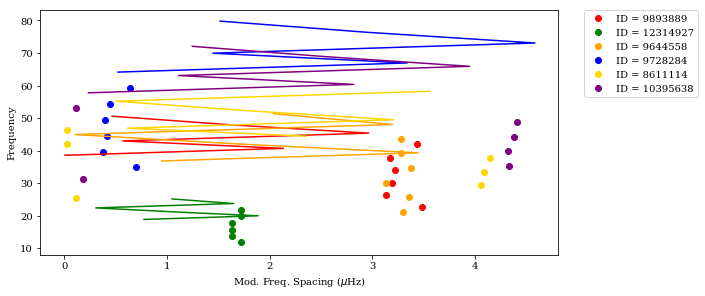

In [50]:
%matplotlib inline
def model(n,dnu,nmax,eps,alpha,A,G,phi,tau):
    s = (n + eps + ((alpha/2)*(nmax-n)**2) + (((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)))*dnu#*np.exp(-n/(tau))
    return s


fig = plt.figure(1, figsize=(12,4))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.6,0.85])

import itertools
colours1 = itertools.cycle(('red', 'green', 'orange', 'blue', 'gold', 'purple'))
colours2 = itertools.cycle(('red', 'green', 'orange', 'blue', 'gold', 'purple'))
    
for i in np.arange(0,len(IDs),1):
    ax.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label=r'ID = '+str(IDs[i]), c=next(colours1))
  
    g2 = model(arr_n[i],
           np.mean(fit['dnu'], axis=0)[i],
           np.mean(fit['nmax'], axis=0)[i],
           np.mean(fit['epsilon'], axis=0)[i],
           np.mean(fit['alpha'], axis=0)[i],
           np.mean(fit['A'], axis=0)[i],
           np.mean(fit['G'], axis=0)[i],
           np.mean(fit['phi'], axis=0)[i],
           np.mean(fit['tau'], axis=0)[i])
    
    ax.plot(g2 % np.mean(fit['dnu'], axis=0)[i], g2,
             c=next(colours2))
'''    
g1 = model(arr_n[0],
           np.mean(fit['dnu'], axis=0)[0],
           np.mean(fit['nmax'], axis=0)[0],
           np.mean(fit['epsilon'], axis=0)[0],
           np.mean(fit['alpha'], axis=0)[0],
           np.mean(fit['A'], axis=0)[0],
           np.mean(fit['G'], axis=0)[0],
           np.mean(fit['phi'], axis=0)[0],
           np.mean(fit['tau'], axis=0)[0])
    
plt.plot(g1 % np.mean(fit['dnu'], axis=0)[0], g1,
             label='Fit_2D')
 
'''       

print(arr_n[0])
print(np.mean(fit['dnu'], axis=0))
print(dnu_avgID)
print(np.mean(fit['nmax'], axis=0))
print(np.mean(fit['epsilon'], axis=0))
print(np.mean(fit['alpha'], axis=0))
print(np.mean(fit['A'], axis=0))
print(np.mean(fit['G'], axis=0))
print(np.mean(fit['phi'], axis=0))
print(np.mean(fit['tau'], axis=0))


plt.legend()
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ($\mu$Hz)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('seminar/somergbseizure.pdf', bbox='tight_layout')

In [37]:
#fitdf = fit.to_dataframe(permuted=True)
#display(fitdf)